ver 8 (6), v10

# **Import lib**

In [8]:
import numpy as np
import os, PIL
from PIL import Image, ImageDraw
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

import cv2, json
from tqdm import tqdm 
import matplotlib.pyplot as plt

import random
from scipy.spatial import ConvexHull

# thư viện cần để chạy code nhduong
from skimage.transform import resize
from skimage.io import imread
import time
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, MaxPooling2D,
    UpSampling2D, Reshape, Permute
)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split 

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from typing import Tuple, List, Optional, Dict, Any

from tqdm.notebook import tqdm # Thanh tiến trình

# **Chuẩn bị tập dữ liệu**

In [2]:
# Đọc file Excel
file_path = '/kaggle/input/btxrd-data/classification.xlsx'
df = pd.read_excel(file_path)

# Hiển thị 10 dòng đầu tiên
df.head(10)

,image_id,center,age,gender,neoplasm,tumor_type,img_type,skeletal_type,bones_type,points,area,image_area,tumor_ratio,is_type,image_filename
0,IMG000001,1,48,F,malignant,other mt,frontal,pelvis,hip bone,"[[[2027.9285714285713, 1219.9285714285713], [2...",294967,7701561.0,3.83,test,IMG000001.jpeg
1,IMG000002,1,12,M,malignant,osteosarcoma,frontal,lower limb,tibia,"[[[895.6756756756756, 614.1981981981984], [895...",131041,4972480.0,2.64,train,IMG000002.jpeg
2,IMG000003,1,12,M,malignant,osteosarcoma,lateral,lower limb,tibia,"[[[811.7117117117116, 729.5135135135137], [831...",120650,6900832.0,1.75,train,IMG000003.jpeg
3,IMG000004,1,52,M,malignant,osteosarcoma,frontal,lower limb,foot,"[[[1302.6698113207547, 1734.9056603773583], [1...",91065,7214337.0,1.26,train,IMG000004.jpeg
4,IMG000005,1,52,M,malignant,osteosarcoma,oblique,lower limb,foot,"[[[1294.2446043165467, 1594.1870503597122], [1...",88469,7017152.0,1.26,train,IMG000005.jpeg
5,IMG000006,1,62,M,malignant,osteosarcoma,frontal,lower limb,femur,"[[[591.9130434782609, 1916.3043478260868], [47...",806550,5627824.0,14.33,train,IMG000006.jpeg
6,IMG000007,1,62,M,malignant,osteosarcoma,lateral,lower limb,femur,"[[[868.3636363636363, 420.45454545454544], [92...",592080,5172384.0,11.45,train,IMG000007.jpeg
7,IMG000008,1,6,M,malignant,osteosarcoma,frontal,upper limb,humerus,"[[[585.0, 904.7058823529412], [577.35294117647...",61063,2650000.0,2.30,train,IMG000008.jpeg
8,IMG000009,1,6,M,malignant,osteosarcoma,frontal,upper limb,humerus,"[[[671.6216216216216, 1090.9819819819818], [64...",49362,3085000.0,1.60,train,IMG000009.jpeg
9,IMG000010,1,16,M,malignant,osteosarcoma,frontal,upper limb,humerus,"[[[327.1296296296297, 1343.1604938271603], [36...",130881,4866640.0,2.69,train,IMG000010.jpeg


In [1]:
image_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/images"
annotation_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations"

classification_file_path = '/kaggle/input/btxrd-data/classification.xlsx'
train_file_path = '/kaggle/input/btxrd-data/train.xlsx'
val_file_path = '/kaggle/input/btxrd-data/val.xlsx'
test_file_path = '/kaggle/input/btxrd-data/test.xlsx'

image_v2 = "/kaggle/input/btxrd-data/btxrd_v2/images" 
annotation_v2 = "/kaggle/input/btxrd-data/btxrd_v2/Annotations" 

In [4]:
df_class = pd.read_excel(classification_file_path)

tumor_types = df_class['tumor_type'].dropna().unique()

summary = {}

for tumor in tumor_types:
    mask = df_class['tumor_type'] == tumor
    counts = df_class[mask].groupby('is_type').size()

    summary[tumor] = {
        'train': int(counts.get('train', 0)),
        'val': int(counts.get('val', 0)),
        'test': int(counts.get('test', 0)),
    }

df_summary = pd.DataFrame.from_dict(summary, orient='index')
df_summary.index.name = 'Tumor Type'

df_summary['total'] = df_summary.sum(axis=1)

print(df_summary)

                          train  val  test  total
Tumor Type                                       
other mt                     29   11     5     45
osteosarcoma                221   53    23    297
synovial osteochondroma      35   13     2     50
giant cell tumor             65   20     8     93
simple bone cyst            153   37    16    206
other bt                     86   22     7    115
osteochondroma              547  138    69    754
multiple osteochondromas    178   66    19    263
osteofibroma                 23   14     7     44


# **Tiền xử lý dữ liệu**
Scale factor: 0.1, Target size: 512x512

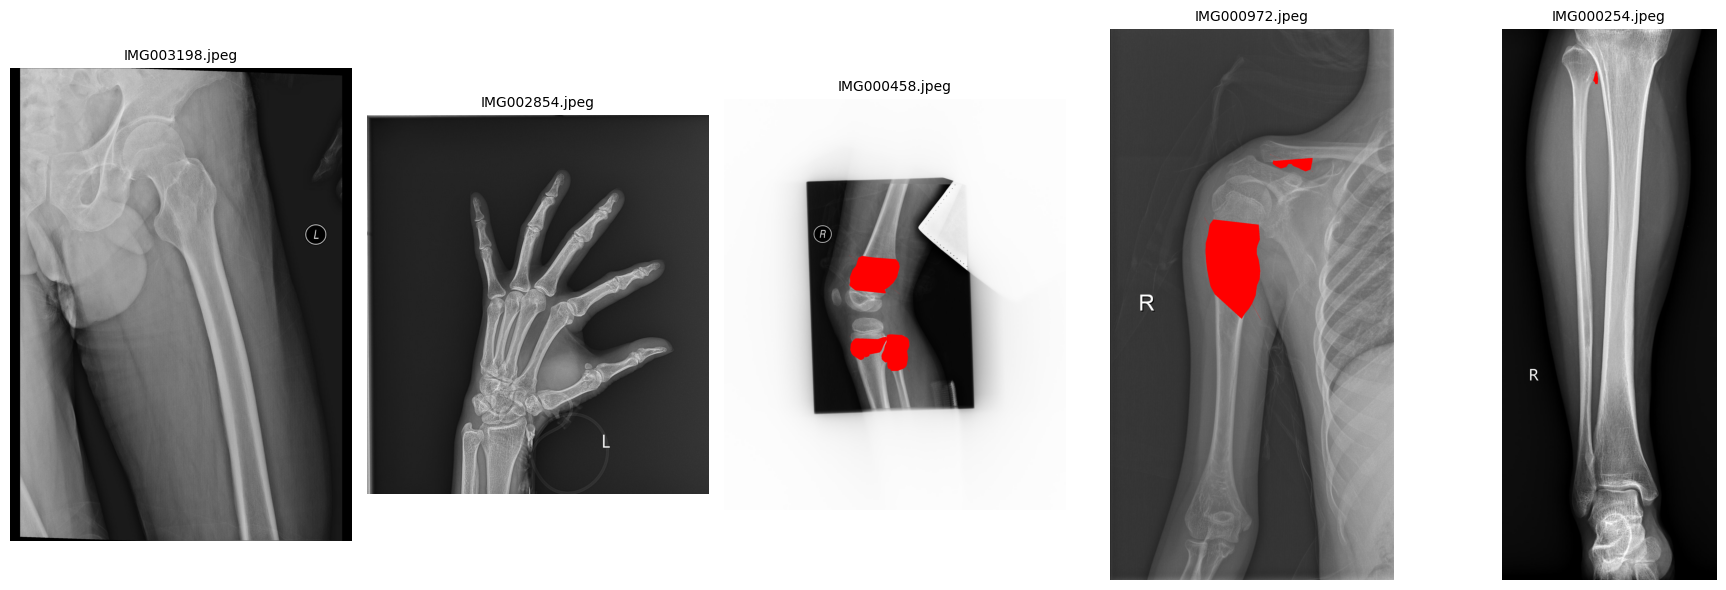

In [26]:
# xuất ngẫu nhiên 5 ảnh trước khi xử lý
num_images_to_show = 5
mask_color = [255, 0, 0]

def create_mask(img_size: Tuple[int, int], ann_path: str) -> np.ndarray:
    mask = Image.new('L', img_size, 0)

    # Kiểm tra xem file annotation
    if os.path.exists(ann_path):
        try:
            with open(ann_path, 'r') as f:
                data = json.load(f)
                for shape in data.get('shapes', []):
                    points = shape.get('points', [])
                    polygon_points = [(int(x), int(y)) for x, y in points]
                    if polygon_points:
                        ImageDraw.Draw(mask).polygon(polygon_points, outline=1, fill=1)
        except json.JSONDecodeError:
            print(f"Báo lỗi file json: {ann_path}")
        except Exception as e:
            print(f"Báo lỗi annotation {ann_path}: {e}")
    return np.array(mask)

try:
    df = pd.read_excel(classification_file_path)
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file classification tại: {classification_file_path}")
    exit() 

all_filenames = df['image_filename'].dropna().tolist()

if not all_filenames:
    print("Không tìm thấy tên file ảnh trong file Excel.")
    exit()

num_to_sample = min(num_images_to_show, len(all_filenames))
if num_to_sample < num_images_to_show:
     print(f"Cảnh báo số lượng vượt quá số lượng ảnh có sẳn")

# Chọn ngẫu nhiên các tên file ảnh
selected_filenames = random.sample(all_filenames, num_to_sample)

# Chuẩn bị plot
plt.figure(figsize=(18, 6))

# Xử lý và hiển thị từng ảnh đã chọn
plot_index = 1
for fname in selected_filenames:
    # Tạo đường dẫn đầy đủ đến file ảnh và file chú thích
    img_path = os.path.join(image_dir, fname)
    ann_fname = os.path.splitext(fname)[0] + '.json'
    ann_path = os.path.join(annotation_dir, ann_fname)

    try:
        img_pil = Image.open(img_path).convert('L')
        img_np = np.array(img_pil) # Chuyển ảnh PIL thành mảng NumPy

        mask_np = create_mask(img_pil.size, ann_path)

        color_img = np.stack([img_np] * 3, axis=-1)

        color_img[mask_np == 1] = mask_color

        plt.subplot(1, num_to_sample, plot_index)
        plt.imshow(color_img)
        plt.title(fname, fontsize=10)
        plt.axis('off')
        plot_index += 1

    except FileNotFoundError:
        print(f"Không tìm thấy ảnh {img_path}")
        continue 
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {fname}: {e}")
        continue

plt.tight_layout()
plt.show()

In [28]:
SCALE_FACTOR = 0.1 # Scale về 10%
TARGET_SIZE = 512

In [29]:
output_dir = "/kaggle/working/btxrd_v2"
output_image_dir = os.path.join(output_dir, "images")
output_anno_dir = os.path.join(output_dir, "Annotations")

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_anno_dir, exist_ok=True)

MAX_VISUALIZATIONS = 5 # Số lượng ảnh tối đa để trực quan hóa
visualized_count = 0

def get_bounding_box(points):
    if not points:
        return None
    points_array = np.array(points)
    xmin = int(np.min(points_array[:, 0]))
    ymin = int(np.min(points_array[:, 1]))
    xmax = int(np.max(points_array[:, 0]))
    ymax = int(np.max(points_array[:, 1]))
    # Đảm bảo tọa độ không âm
    xmin = max(0, xmin)
    ymin = max(0, ymin)
    return (xmin, ymin, xmax, ymax)

try:
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    total_images = len(image_files)
    if total_images == 0:
        print(f"Không tìm thấy file ảnh nào trong: {image_dir}")
        exit()
    print(f"Tìm thấy {total_images} ảnh để xử lý.")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy thư mục ảnh: {image_dir}")
    exit()

Tìm thấy 3746 ảnh để xử lý.


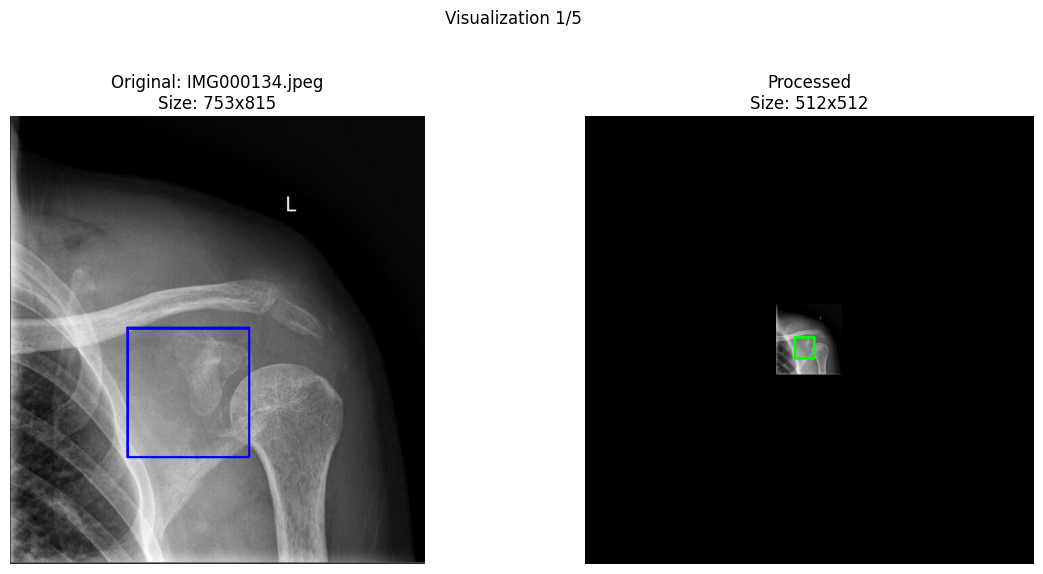

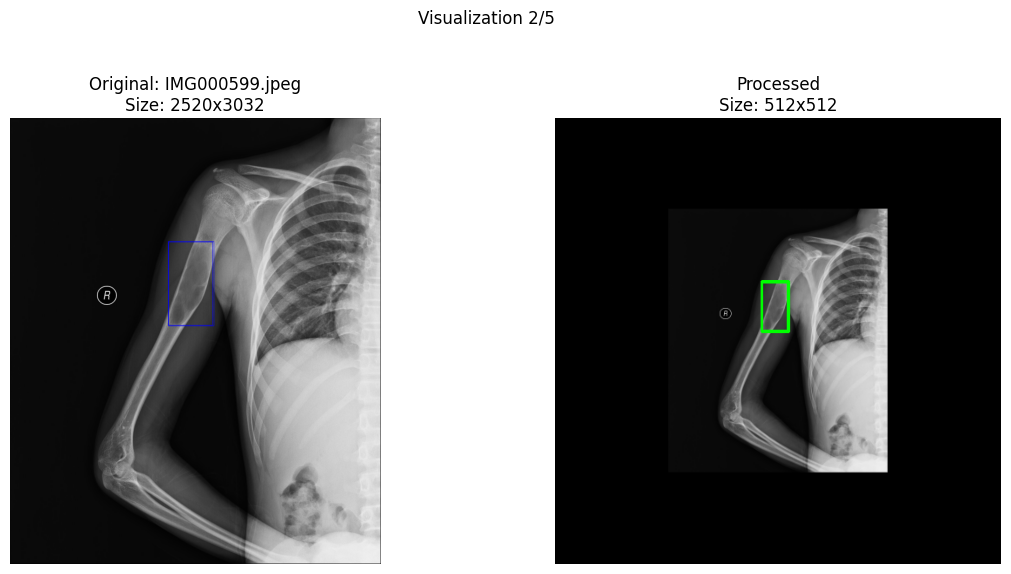

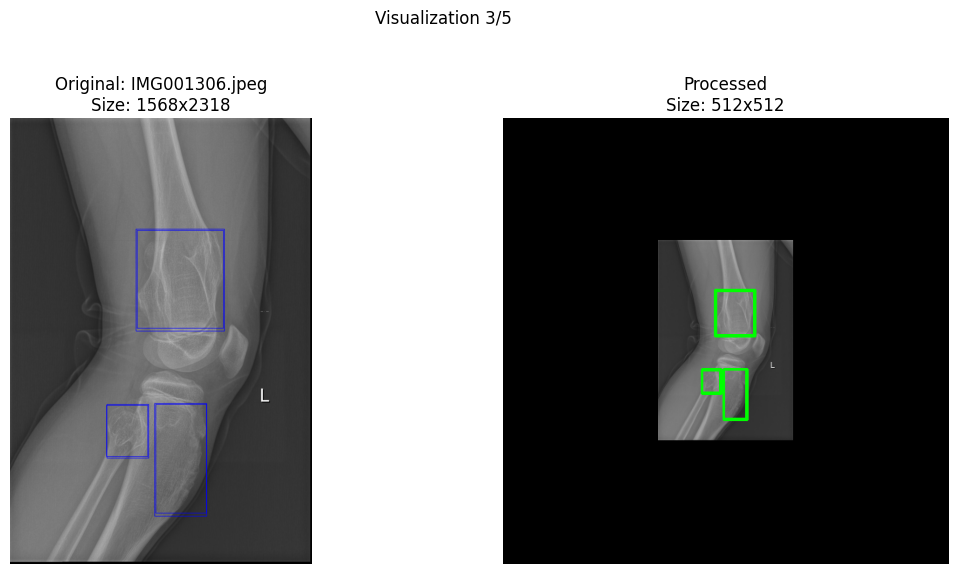

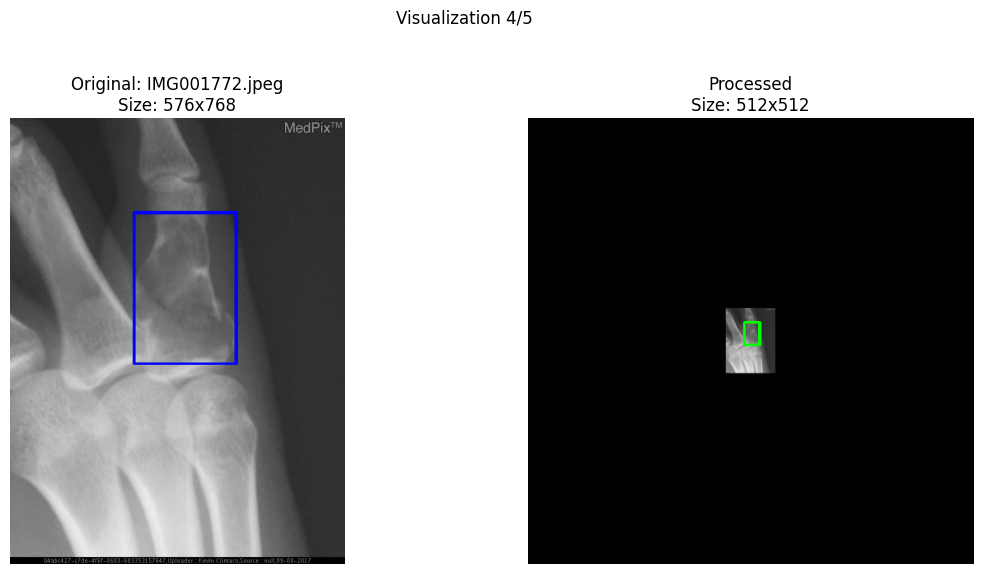

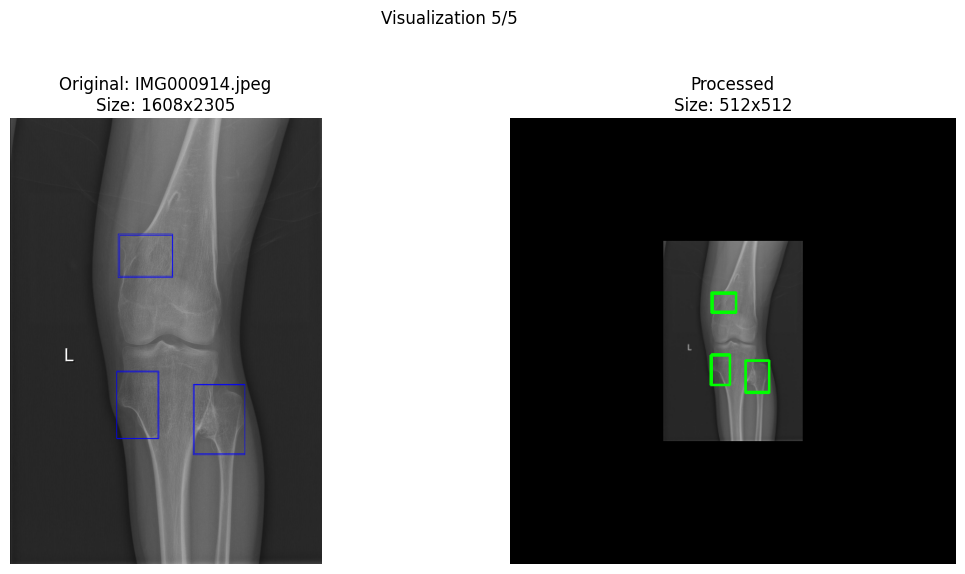

Ảnh và annotation đã xử lý được lưu tại: /kaggle/working/btxrd_v2


In [30]:
for file in image_files:
    img_path = os.path.join(image_dir, file)
    anno_filename = file.rsplit('.', 1)[0] + '.json'
    anno_path = os.path.join(annotation_dir, anno_filename)

    img_orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_orig is None:
        # print(f"Không thể đọc ảnh: {file}") # Có thể bỏ comment nếu muốn thấy lỗi cụ thể trong log tqdm
        continue
    orig_height, orig_width = img_orig.shape[:2]

    # Đọc annotation gốc (nếu có)
    annotation_orig = None
    has_annotation = os.path.exists(anno_path)
    if has_annotation:
        try:
            with open(anno_path, "r", encoding="utf-8") as f:
                annotation_orig = json.load(f)
        except Exception as e:
            # print(f"Lỗi khi đọc annotation {anno_filename}: {e}") # Bỏ comment nếu cần debug
            has_annotation = False

    # Chuẩn bị cho trực quan hóa (NẾU cần)
    img_to_draw_orig = None
    img_to_draw_padded = None
    original_bboxes = []
    transformed_bboxes = []

    should_visualize = has_annotation and (visualized_count < MAX_VISUALIZATIONS)

    if should_visualize:
        img_to_draw_orig = cv2.cvtColor(img_orig, cv2.COLOR_GRAY2BGR)
        if annotation_orig and "shapes" in annotation_orig:
             for shape in annotation_orig["shapes"]:
                if "points" in shape and shape["points"]:
                    bbox = get_bounding_box(shape["points"])
                    if bbox:
                        original_bboxes.append(bbox)
                        cv2.rectangle(img_to_draw_orig, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255), 2) # Red

    # Resize ảnh 
    new_width = max(1, int(orig_width * SCALE_FACTOR))
    new_height = max(1, int(orig_height * SCALE_FACTOR))
    img_resized = cv2.resize(img_orig, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # thêm padding
    pad_h = TARGET_SIZE - new_height
    pad_w = TARGET_SIZE - new_width
    top = max(0, pad_h // 2)
    bottom = max(0, pad_h - top)
    left = max(0, pad_w // 2)
    right = max(0, pad_w - left)
    padded_img = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0) 

    # Lưu ảnh đã xử lý
    output_img_path = os.path.join(output_image_dir, file)
    try:
        cv2.imwrite(output_img_path, padded_img)
    except Exception as e:
        # print(f"Lỗi khi lưu ảnh {output_img_path}: {e}") # Bỏ comment nếu cần debug
        continue

    # Xử lý và lưu annotation (nếu có)
    if has_annotation and annotation_orig:
        annotation_new = json.loads(json.dumps(annotation_orig)) # Deep copy
        if "shapes" in annotation_new:
            for shape in annotation_new["shapes"]:
                if "points" in shape and shape["points"]:
                    original_points = shape["points"]
                    new_points_transformed = []
                    for x, y in original_points:
                        new_x = (x * SCALE_FACTOR) + left
                        new_y = (y * SCALE_FACTOR) + top
                        new_points_transformed.append([new_x, new_y])
                    shape["points"] = new_points_transformed

                    if should_visualize:
                        new_bbox = get_bounding_box(new_points_transformed)
                        if new_bbox:
                            transformed_bboxes.append(new_bbox)

            annotation_new["imageWidth"] = TARGET_SIZE
            annotation_new["imageHeight"] = TARGET_SIZE

            output_annotation_path = os.path.join(output_anno_dir, anno_filename)
            try:
                with open(output_annotation_path, "w", encoding="utf-8") as f:
                    json.dump(annotation_new, f, indent=4)
            except Exception as e:
                pass 

            # Trực quan hóa 
            if should_visualize and img_to_draw_orig is not None:
                img_to_draw_padded = cv2.cvtColor(padded_img, cv2.COLOR_GRAY2BGR)
                for bbox in transformed_bboxes:
                     cv2.rectangle(img_to_draw_padded, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2) # Green

                fig, axes = plt.subplots(1, 2, figsize=(12, 6))
                axes[0].imshow(img_to_draw_orig)
                axes[0].set_title(f'Original: {file}\nSize: {orig_width}x{orig_height}')
                axes[0].axis('off')
                axes[1].imshow(img_to_draw_padded)
                axes[1].set_title(f'Processed\nSize: {TARGET_SIZE}x{TARGET_SIZE}')
                axes[1].axis('off')
                plt.suptitle(f"Visualization {visualized_count + 1}/{MAX_VISUALIZATIONS}")
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()
                visualized_count += 1

print(f"Ảnh và annotation đã xử lý được lưu tại: {output_dir}")

Có 1867 ảnh có khối u

Xoay random 5 ảnh
 IMG000644.jpeg
 IMG001842.jpeg
 IMG001089.jpeg
 IMG000928.jpeg
 IMG000806.jpeg


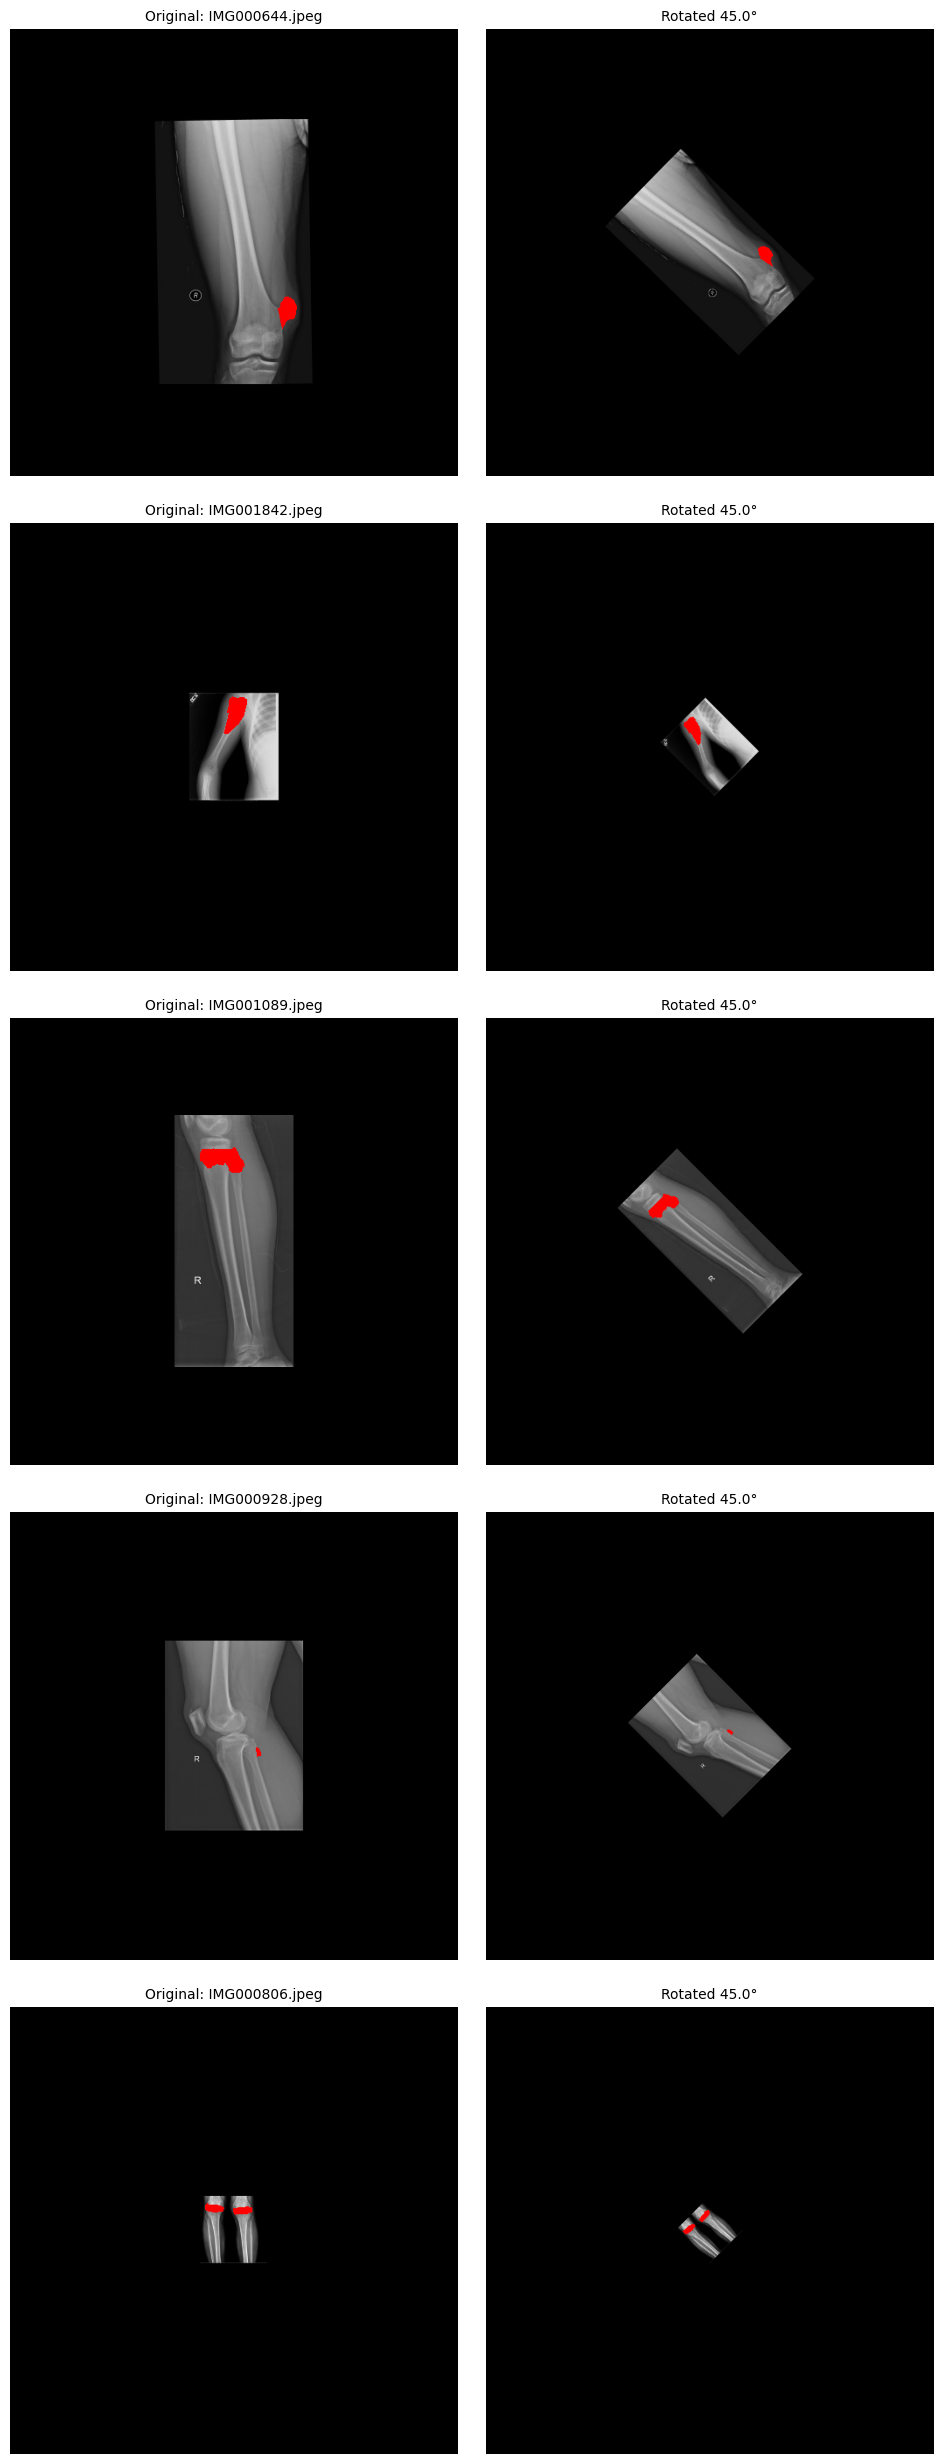

In [19]:
# kiểm tra xem khi xoay ảnh, mask có xoay không
rotation_angle: float = 45.0
num_visualizations: int = 5
mask_color: List[int] = [255, 0, 0]
rotation_fill_color: int = 0 # Màu nền khi xoay

# Tạo mask từ file json
def create_mask_pil(img_size: Tuple[int, int], ann_path: str) -> Image.Image:
    mask = Image.new('L', img_size, 0)
    if os.path.exists(ann_path):
        try:
            with open(ann_path, 'r') as f:
                data = json.load(f)
                draw = ImageDraw.Draw(mask)
                for shape in data.get('shapes', []):
                    points = shape.get('points', [])
                    polygon_points = [(int(x), int(y)) for x, y in points]
                    if len(polygon_points) > 2:
                        draw.polygon(polygon_points, outline=1, fill=1)
        except json.JSONDecodeError:
            print(f"Lỗi JSON file: {ann_path}")
        except Exception as e:
            print(f"Lỗi khi đọc {ann_path}: {e}")
    return mask
    
# Áp dụng mask màu lên ảnh
def apply_mask(image_np: np.ndarray, mask_np: np.ndarray, color: List[int]) -> np.ndarray:
    if image_np.ndim == 2:
        color_img = np.stack([image_np] * 3, axis=-1)
    elif image_np.ndim == 3 and image_np.shape[2] == 1:
        color_img = np.concatenate([image_np] * 3, axis=-1)
    elif image_np.ndim == 3 and image_np.shape[2] == 3:
        color_img = image_np.copy()
    else:
        raise ValueError(f"Định dạng ảnh không hỗ trợ: {image_np.shape}")
    mask_bool = mask_np.astype(bool)
    color_img[mask_bool] = color
    return color_img

def get_valid_paths(base_dir_img: str, base_dir_ann: str, full_fname_from_excel: str) -> Optional[Tuple[str, str]]:
    # sử dụng tên file đầy đủ từ Excel để tạo đường dẫn ảnh
    img_path = os.path.join(base_dir_img, full_fname_from_excel)

    # Kiểm tra ảnh tồn tại
    if not os.path.exists(img_path):
        # print(f"Ảnh không tồn tại: {img_path}")
        return None

    # Tạo đường dẫn json từ tên file đầy đủ
    json_filename = os.path.splitext(full_fname_from_excel)[0] + '.json'
    json_path = os.path.join(base_dir_ann, json_filename)

    # Kiểm tra JSON tồn tại
    if not os.path.exists(json_path):
        # print(f"Annotation không tồn tại: {json_path}") 
        return None
        
    return img_path, json_path

# vẽ ảnh trên trục
def plot_image(ax: plt.Axes, image_data: np.ndarray, title: str):
    ax.imshow(image_data)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

# Lấy danh sách file ảnh từ excel
valid_files_details: Dict[str, Dict[str, str]] = {}
try:
    df = pd.read_excel(classification_file_path)
    if 'image_filename' not in df.columns:
        print(f"Không tìm thấy cột image_filename")
        exit()

    for full_filename in df['image_filename'].dropna().unique():
        paths = get_valid_paths(image_v2, annotation_v2, full_filename)
        if paths:
            img_path, json_path = paths
            # Lưu trữ đường dẫn hợp lệ, key là tên file đầy đủ
            valid_files_details[full_filename] = {'img_path': img_path, 'json_path': json_path}

    if not valid_files_details:
        print("\nKhông tìm thấy cặp file ảnh và annotation nào dựa trên excel")
        print(f"Kiểm tra nội dung cột image_filename và sự tồn tại của file \nẢnh: {image_v2}, Anno: {annotation_v2}")
        exit()

    print(f"Có {len(valid_files_details)} ảnh có khối u")

except FileNotFoundError:
    print(f"Không tìm thấy file excel tại: {classification_file_path}")
    exit()
except Exception as e:
    print(f"Lỗi khi đọc hoặc xử lý file excel: {e}")
    exit()

# Chọn ngẫu nhiên ảnh
available_fnames = list(valid_files_details.keys())
num_to_select = min(num_visualizations, len(available_fnames))
if num_to_select < num_visualizations:
     print(f"Chỉ có {num_to_select} ảnh hợp lệ")
elif num_to_select == 0:
    print("Không có ảnh nào để hiển thị.")
    exit()

selected_files = random.sample(available_fnames, num_to_select)
print(f"\nXoay random {num_to_select} ảnh")

# Xử lý và hiển thị 
plt.figure(figsize=(10, 5 * num_to_select))
plot_num = 1
for fname in selected_files:
    print(f" {fname}")
    details = valid_files_details[fname] # Lấy đường dẫn đã lưu

    try:
        # Ảnh và mask trước khi xoay
        img_orig_pil = Image.open(details['img_path']).convert('L')
        mask_orig_pil = create_mask_pil(img_orig_pil.size, details['json_path'])
        overlay_orig_np = apply_mask(np.array(img_orig_pil), np.array(mask_orig_pil), mask_color)

        # Xoay Ảnh và mask
        img_rotated_pil = img_orig_pil.rotate(rotation_angle, resample=Image.Resampling.NEAREST, expand=True, fillcolor=rotation_fill_color)
        mask_rotated_pil = mask_orig_pil.rotate(rotation_angle, resample=Image.Resampling.NEAREST, expand=True, fillcolor=0)
        overlay_rotated_np = apply_mask(np.array(img_rotated_pil), np.array(mask_rotated_pil), mask_color)

        # Vẽ subplot
        ax1 = plt.subplot(num_to_select, 2, plot_num)
        plot_image(ax1, overlay_orig_np, f"Original: {fname}")
        plot_num += 1

        ax2 = plt.subplot(num_to_select, 2, plot_num)
        plot_image(ax2, overlay_rotated_np, f"Rotated {rotation_angle}°")
        plot_num += 1

    except FileNotFoundError:
        print(f"Không tìm thấy file {fname}")
        if plot_num % 2 == 0: plot_num -=1
    except Exception as e:
        print(f"không xác định được {fname}: {e}")
        if plot_num % 2 == 0: plot_num -=1

plt.tight_layout(pad=2.0)
plt.show()

# **Load data**

In [9]:
TARGET_SIZE = 512
N_CLASSES = 2 # 0: background, 1: tumor
BATCH_SIZE = 8
BUFFER_SIZE = 100 # Kích thước bộ đệm cho shuffle

In [10]:
# Kiểm tra file

# Áp dụng mask màu lên ảnh 
def apply_mask_visualization(image_np: np.ndarray, mask_np: np.ndarray, tumor_color: List[int] = [255, 0, 0]) -> np.ndarray:
    if image_np.ndim == 2: # Grayscale
        color_img = np.stack([image_np] * 3, axis=-1)
    elif image_np.ndim == 3 and image_np.shape[2] == 1: # Grayscale với channel dim
        color_img = np.concatenate([image_np] * 3, axis=-1)
    elif image_np.ndim == 3 and image_np.shape[2] == 3: # Already color
        color_img = image_np.copy()
    else:
        # Fallback: Chuyển về grayscale nếu không rõ định dạng
        print(f"Warning: Định dạng ảnh không xác định {image_np.shape}, cố gắng chuyển về grayscale.")
        if image_np.ndim == 3:
             image_gray = image_np.mean(axis=-1) # Cách đơn giản để grayscale
        else:
             image_gray = image_np # Giữ nguyên nếu là 1D/2D?
        color_img = np.stack([image_gray] * 3, axis=-1)

    # Đảm bảo ảnh ở dạng uint8 để tô màu
    if color_img.dtype != np.uint8:
         # giả định ảnh gốc đã được scale về [0, 255] hoặc cần scale lại
         if color_img.max() <= 1.0 and color_img.min() >= 0.0:
              color_img = (color_img * 255).astype(np.uint8)
         else: # Giả sử đã trong khoảng nhưng sai dtype
              color_img = np.clip(color_img, 0, 255).astype(np.uint8)


    mask_bool = mask_np.astype(bool) # Mask là 0 hoặc 1
    color_img[mask_bool] = tumor_color
    return color_img

def plot_image(ax: plt.Axes, image_data: np.ndarray, title: str):
    # Kiểm tra nếu ảnh là grayscale thì dùng cmap='gray'
    if image_data.ndim == 2 or (image_data.ndim == 3 and image_data.shape[2] == 1):
        ax.imshow(image_data, cmap='gray')
    else:
        ax.imshow(image_data)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

all_image_paths = []
all_mask_paths = []
all_types = [] # train, val, test

try:
    df_classification = pd.read_excel(classification_file_path)
    if 'image_filename' not in df_classification.columns or 'is_type' not in df_classification.columns:
        raise ValueError("Excel file must contain 'image_filename' and 'is_type' columns.")

    processed_files = 0
    found_pairs = 0
    for index, row in tqdm(df_classification.iterrows(), total=len(df_classification), desc="Checking files"):
        img_filename = row['image_filename']
        file_type = row['is_type']
        if pd.isna(img_filename) or pd.isna(file_type):
            # print(f"Skipping row {index+2} due to missing data.")
            continue

        paths = get_valid_paths(image_v2, annotation_v2, img_filename)
        processed_files += 1
        if paths:
            img_path, json_path = paths
            all_image_paths.append(img_path)
            all_mask_paths.append(json_path) # Lưu đường dẫn JSON
            all_types.append(file_type)
            found_pairs += 1
        # else:
            # print(f"Info: No valid pair found for {img_filename}")


    print(f"Processed {processed_files} filenames from excel")
    print(f"Found {found_pairs} valid image-annotation")

    if found_pairs == 0:
        print("\nKhông tìm thấy ảnh json")
        print(f" - Excel file path: {classification_file_path}")
        print(f" - Image directory: {image_v2}")
        print(f" - Annotation (JSON) directory: {annotation_v2}")
        print(f" - 'image_filename' column in Excel matches actual image filenames.")
        print(f" - Corresponding '.json' files exist in the annotation directory.")
        exit()

    # Chia dữ liệu
    df_paths = pd.DataFrame({
        'image_path': all_image_paths,
        'mask_path': all_mask_paths,
        'type': all_types
    })

    df_train = df_paths[df_paths['type'] == 'train'].reset_index(drop=True)
    df_val = df_paths[df_paths['type'] == 'val'].reset_index(drop=True)
    df_test = df_paths[df_paths['type'] == 'test'].reset_index(drop=True)

    train_image_paths = df_train['image_path'].tolist()
    train_mask_paths = df_train['mask_path'].tolist() # List of JSON paths
    val_image_paths = df_val['image_path'].tolist()
    val_mask_paths = df_val['mask_path'].tolist()
    test_image_paths = df_test['image_path'].tolist()
    test_mask_paths = df_test['mask_path'].tolist()

    print(f"Train: {len(train_image_paths)}")
    print(f"Valid: {len(val_image_paths)}")
    print(f"Test: {len(test_image_paths)}")

    if not train_image_paths:
         print("Không tìm thấy tập train")
    if not val_image_paths:
         print("Không tìm thấy tập valid")
    if not test_image_paths:
         print("Không tìm thấy tập test")


except FileNotFoundError:
    print(f"Classification file not found at {classification_file_path}")
    exit()
except ValueError as e:
    print(f"Error: {e}")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during metadata loading: {e}")
    exit()




Checking files:   0%|          | 0/3746 [00:00<?, ?it/s]

Processed 3719 filenames from excel
Found 1867 valid image-annotation
Train: 1337
Valid: 374
Test: 156


In [11]:
# Tính Mean và Std trên ảnh thuộc tập train
mean_pixel = 0.5 
std_pixel = 0.1 
num_train_images = len(train_image_paths)

if num_train_images > 0:
    pixel_sum = 0.0
    pixel_sum_sq = 0.0
    total_pixels = 0
    processed_count = 0

    for img_path in tqdm(train_image_paths, desc="Calculating Mean/Std"):
        try:
            img = tf.io.read_file(img_path)
            img = tf.image.decode_image(img, channels=1, expand_animations=False) # Decode bất kỳ định dạng nào, grayscale
            img = tf.image.resize(img, [TARGET_SIZE, TARGET_SIZE])
            img = tf.cast(img, tf.float32) / 255.0 # Normalize to [0, 1]

            pixel_sum += tf.reduce_sum(img).numpy()
            pixel_sum_sq += tf.reduce_sum(tf.square(img)).numpy()
            total_pixels += (TARGET_SIZE * TARGET_SIZE)
            processed_count += 1

        except Exception as e:
            print(f"Could not process image {img_path} for mean/std. Error: {e}")

    if processed_count > 0 and total_pixels > 0:
        mean_pixel = pixel_sum / total_pixels
        variance = (pixel_sum_sq / total_pixels) - (mean_pixel ** 2)
        std_pixel = np.sqrt(max(variance, 1e-7)) # Tránh số âm nhỏ
        print(f"Calculated Mean: {mean_pixel:.4f}")
        print(f"Calculated Std Dev: {std_pixel:.4f}")
    else:
         print(f"No images processed successfully for mean/std. Using defaults.")

else:
    print("No training images to calculate mean/std. Using defaults.")

Calculating Mean/Std:   0%|          | 0/1337 [00:00<?, ?it/s]

Calculated Mean: 0.0340
Calculated Std Dev: 0.1221


In [13]:
# Hàm Wrapper Python để tải Mask từ JSON 
# được gọi bởi tf.py_function
def load_mask_from_json_py(json_path_bytes):
    json_path = json_path_bytes.numpy().decode('utf-8')
    pil_mask = create_mask_pil((TARGET_SIZE, TARGET_SIZE), json_path)
    mask_np = np.array(pil_mask, dtype=np.uint8) # Output là uint8 (0 hoặc 1)
    # print(f" Mask Shape from py_func: {mask_np.shape}") # Debug
    return mask_np

# Hàm tiền xử lý và tải dữ liệu với tf.py_function
@tf.function # Tăng tốc độ xử lý
def load_and_preprocess(image_path, mask_json_path):
    img = tf.io.read_file(image_path)
    try:
        img = tf.image.decode_image(img, channels=1, expand_animations=False)
    except: # Fallback nếu decode_image lỗi 
         img = tf.image.decode_jpeg(img, channels=1) # Thử jpeg

    img = tf.image.resize(img, [TARGET_SIZE, TARGET_SIZE])
    img = tf.cast(img, tf.float32)

    # Đọc mask dùng tf.py_function
    # Input cho py_function phải là Tensor
    mask_np = tf.py_function(
        func=load_mask_from_json_py,
        inp=[mask_json_path], # Truyền tensor đường dẫn json
        Tout=tf.uint8         # Kiểu dữ liệu trả về từ hàm Python
    )
    # Cần set shape vì py_function làm mất thông tin shape
    mask_np.set_shape([TARGET_SIZE, TARGET_SIZE])
    mask = tf.expand_dims(mask_np, axis=-1) # Thêm channel dim -> (H, W, 1)
    mask = tf.cast(mask, tf.uint8)

    # Chuẩn hóa ảnh về [0, 1]
    img = img / 255.0    
    img = (img - mean_pixel) / std_pixel 

    # One-hot encoding
    mask_onehot = tf.one_hot(tf.squeeze(mask, axis=-1), depth=N_CLASSES, dtype=tf.float32)
    # mask_onehot shape: (H, W, N_CLASSES)

    return img, mask_onehot

# Hàm Data Augmentation
@tf.function
def augment_data(image, mask_onehot):
    # Ghép ảnh và mask để cùng áp dụng phép biến đổi hình học
    # Chuyển mask về float để concat
    mask_float = tf.cast(mask_onehot, dtype=tf.float32)
    combined = tf.concat([image, mask_float], axis=-1)

    # Random Flip Left/Right
    combined = tf.image.random_flip_left_right(combined)

    # Tách lại ảnh và mask
    img_aug = combined[..., :1]  # Ảnh có 1 channel
    mask_aug = combined[..., 1:] # Mask có N_CLASSES channels

    # Random Brightness/Contrast (chỉ áp dụng cho ảnh)
    img_aug = tf.image.random_brightness(img_aug, max_delta=0.1)
    img_aug = tf.image.random_contrast(img_aug, lower=0.9, upper=1.1)
    # Clip lại giá trị ảnh sau chuẩn hóa mean/std 
    # img_aug = tf.clip_by_value(img_aug, -3.0, 3.0)

    mask_aug = tf.cast(mask_aug, tf.float32)

    return img_aug, mask_aug


def create_dataset(image_paths, mask_paths, is_training=True):
    if not image_paths or not mask_paths:
        print(f"Warning: Cannot create dataset because path list is empty (training={is_training}).")
        return None

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    # Shuffle trước khi map để tăng tính ngẫu nhiên (đặc biệt quan trọng nếu dùng py_function)
    if is_training:
        dataset = dataset.shuffle(buffer_size=min(BUFFER_SIZE, len(image_paths)))

    # Áp dụng load và preprocess
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) #AUTOTUNE

    if is_training:
        # Augmentation sau khi load và preprocess
        dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch và Prefetch
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [14]:
# load input image and output mask
train_ds = create_dataset(train_image_paths, train_mask_paths, is_training=True)
val_ds = create_dataset(val_image_paths, val_mask_paths, is_training=False)
test_ds = create_dataset(test_image_paths, test_mask_paths, is_training=False)

print(f"Train dataset: {train_ds}")
print(f"Validation dataset: {val_ds}")
print(f"Test dataset: {test_ds}")

Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 2), dtype=tf.float32, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 2), dtype=tf.float32, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 2), dtype=tf.float32, name=None))>


Image batch shape: (8, 512, 512, 1)
Mask batch shape: (8, 512, 512, 2)


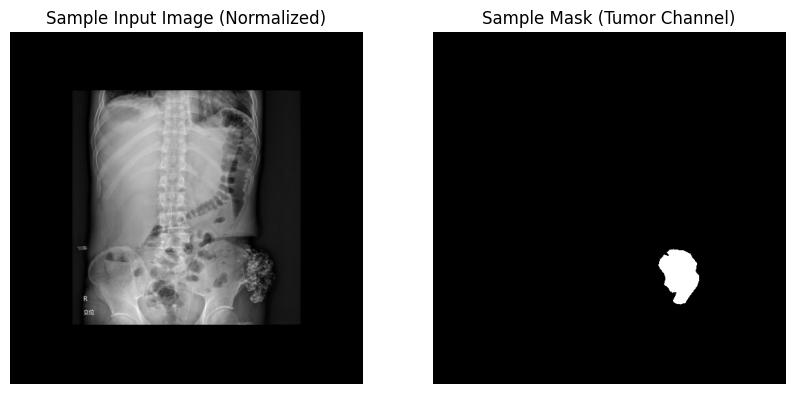

In [21]:
# Kiểm tra thử một batch dữ liệu
if train_ds:
    for images, masks in train_ds.take(1):
        print("Image batch shape:", images.shape) # (BATCH_SIZE, TARGET_SIZE, TARGET_SIZE, 1)
        print("Mask batch shape:", masks.shape)   # (BATCH_SIZE, TARGET_SIZE, TARGET_SIZE, N_CLASSES)
        # Hiển thị thử ảnh và mask đầu tiên
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        # Ảnh đã chuẩn hóa mean/std
        plt.imshow(images[0, :, :, 0].numpy(), cmap='gray')
        plt.title("Sample Input Image (Normalized)")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        # Hiển thị kênh lớp 1 (tumor) từ mask one-hot
        plt.imshow(masks[0, :, :, 1].numpy(), cmap='gray', vmin=0, vmax=1) # Kênh 1 (tumor)
        plt.title("Sample Mask (Tumor Channel)")
        plt.axis('off')
        plt.show()
        break
else:
    print("Skipping sample batch check as training dataset is not available.")


# **Xây dựng mô hình CNN**

In [22]:
def conv_block_cnn(input_tensor, num_filters, kernel_size=(3, 3), activation='relu', batch_norm=True):
    x = layers.Conv2D(num_filters, kernel_size, padding='same')(input_tensor)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

def build_simple_cnn_segmentation(input_shape, n_classes):
    inputs = keras.Input(shape=input_shape)
    filters = [32, 64, 128, 256] # Số filter cho từng block encoder

    # Encoder 
    skips = [] # Lưu output của encoder để dùng trong decoder (nếu cần skip connection)
    x = inputs
    for i, f in enumerate(filters):
        # Hai lớp conv cho mỗi block
        x = conv_block_cnn(x, f, activation='relu')
        x = conv_block_cnn(x, f, activation='relu')
        skips.append(x) # Lưu trước khi pooling
        x = layers.MaxPooling2D((2, 2), name=f'pool_{i+1}')(x)

    # Bottleneck
    x = conv_block_cnn(x, filters[-1] * 2, activation='relu') # Tăng filter ở bottleneck
    x = conv_block_cnn(x, filters[-1] * 2, activation='relu')

    #Decoder 
    # Đảo ngược danh sách filter và skips
    decoder_filters = filters[::-1] # [256, 128, 64, 32]
    skips = skips[::-1]

    for i, f in enumerate(decoder_filters):
        # Upsampling bằng Conv2DTranspose
        x = layers.Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same', name=f'upconv_{i+1}')(x)
        x = conv_block_cnn(x, f, activation='relu')
        x = conv_block_cnn(x, f, activation='relu')

    outputs = layers.Conv2D(n_classes, (1, 1), activation='sigmoid', name='output_layer')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="Simple_CNN_Segmentation")
    return model

input_shape = (TARGET_SIZE, TARGET_SIZE, 1)

model = build_simple_cnn_segmentation(input_shape, N_CLASSES)
model.summary()

Model: "Simple_CNN_Segmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 512, 512, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 512, 512, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 512, 512, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_36 (Activation)           │ (None, 512, 512, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 512, 512, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 512, 512, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_37 (Activation)           │ (None, 512, 512, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 256, 256, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_38 (Activation)           │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_39 (Activation)           │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_40 (Activation)           │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 128, 128, 128)       │         147,5

 Total params: 6,987,970 (26.66 MB)

 Trainable params: 6,982,082 (26.63 MB)

 Non-trainable params: 5,888 (23.00 KB)

# **Compile**

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# Loss BinaryCrossentropy vì output sigmoid và N_CLASSES=2
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [
    'accuracy', # Độ chính xác pixel-wise
    tf.keras.metrics.MeanIoU(num_classes=N_CLASSES, name='mean_iou')
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [26]:
# Callbacks
model_checkpoint_path = "best_simple_cnn_model.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    save_best_only=True,
    monitor='val_mean_iou', 
    mode='max',
    verbose=1
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    patience=15, 
    mode='max',
    restore_best_weights=True,
    verbose=1
)

if train_ds and val_ds:
    EPOCHS = 60

    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[checkpoint_callback, early_stopping_callback]
    )   

Epoch 1/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8771 - loss: 0.5083 - mean_iou: 0.2500
Epoch 1: val_mean_iou improved from -inf to 0.25000, saving model to best_simple_cnn_model.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 76s 342ms/step - accuracy: 0.8776 - loss: 0.5076 - mean_iou: 0.2500 - val_accuracy: 0.9973 - val_loss: 0.4822 - val_mean_iou: 0.2500
Epoch 2/60
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9966 - loss: 0.2594 - mean_iou: 0.2500
Epoch 2: val_mean_iou did not improve from 0.25000
168/168 ━━━━━━━━━━━━━━━━━━━━ 46s 273ms/step - accuracy: 0.9966 - loss: 0.2592 - mean_iou: 0.2500 - val_accuracy: 0.9973 - val_loss: 0.2666 - val_mean_iou: 0.2500
Epoch 3/60
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9974 - loss: 0.2045 - mean_iou: 0.2500
Epoch 3: val_mean_iou improved from 0.25000 to 0.25000, saving model to best_simple_cnn_model.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 46s 276ms/step - accuracy: 0.9974 - loss: 0.2044 - mean_iou: 0.2500 - val_accu

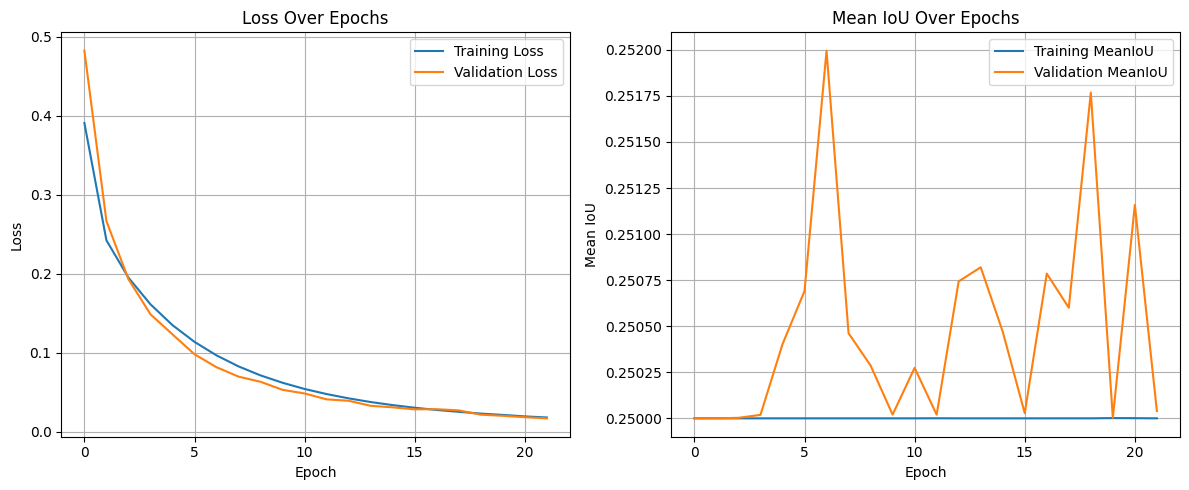

In [27]:
if train_ds and val_ds:
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_iou'], label='Training MeanIoU')
    plt.plot(history.history['val_mean_iou'], label='Validation MeanIoU')
    plt.title('Mean IoU Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean IoU')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

else:
    print("Error: Cannot start training. Training or Validation dataset is missing or empty.")
    # Gán history=None để các bước sau không bị lỗi
    history = None



In [28]:
# Đánh giá trên tập Test
best_model = None 
if test_ds:
    print(f"Loading best model from: {model_checkpoint_path}")
    try:
        # Load model tốt nhất đã lưu
        best_model = tf.keras.models.load_model(model_checkpoint_path)
        print("Best model loaded successfully.")

        results = best_model.evaluate(test_ds, verbose=1)
        print("\nTest Set Evaluation Results (Best Model):")
        # Đảm bảo lấy đúng index của metrics
        metric_names = ['loss'] + [m.name for m in metrics] # ['loss', 'accuracy', 'mean_iou']
        for name, value in zip(metric_names, results):
             print(f"Test {name}: {value:.4f}")

    except Exception as e:
        print(f"Error loading the best model: {e}")
        print("Attempting to evaluate with the current model in memory (if training occurred).")
        if 'model' in locals() and history is not None: # Chỉ đánh giá nếu đã train
             try:
                 results = model.evaluate(test_ds, verbose=1)
                 print("\nTest Set Evaluation Results (Current Model):")
                 metric_names = ['loss'] + [m.name for m in metrics]
                 for name, value in zip(metric_names, results):
                      print(f"Test {name}: {value:.4f}")
                 best_model = model # Sử dụng model hiện tại để dự đoán nếu không load được best
             except Exception as inner_e:
                  print(f"Could not evaluate the current model: {inner_e}")
        else:
            print("No model available for evaluation.")

else:
    print("Warning: Test dataset is not available or empty. Skipping evaluation.")
    # Nếu model đã được train, vẫn có thể dùng model hiện tại
    if 'model' in locals() and history is not None:
        best_model = model
    else:
        # Kiểm tra nếu best_model đã được load trước đó (dù test_ds không có)
        if not best_model and os.path.exists(model_checkpoint_path):
             try:
                  best_model = tf.keras.models.load_model(model_checkpoint_path)
                  print("Loaded best model even though test set is unavailable.")
             except Exception as e:
                  print(f"Could not load best model: {e}")

Loading best model from: best_simple_cnn_model.keras
Best model loaded successfully.
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.9966 - loss: 0.0831 - mean_iou: 0.2514

Test Set Evaluation Results (Best Model):
Error loading the best model: 'str' object has no attribute 'name'
Attempting to evaluate with the current model in memory (if training occurred).
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9966 - loss: 0.0831 - mean_iou: 0.2514

Test Set Evaluation Results (Current Model):
Could not evaluate the current model: 'str' object has no attribute 'name'


In [ ]:
# --- 11. Dự đoán và Hiển thị Kết quả ---
print("\n--- Prediction and Visualization ---")

def display_predictions(dataset, model_to_use, num_samples=5, threshold=0.5):
    """Hiển thị dự đoán của model trên một số mẫu từ dataset."""
    if dataset is None:
        print("Dataset is not available for prediction.")
        return
    if model_to_use is None:
        print("Model is not available for prediction.")
        return

    # Lấy các batch từ dataset
    num_displayed = 0
    for image_batch, true_mask_batch in dataset.take((num_samples + BATCH_SIZE - 1) // BATCH_SIZE): # Lấy đủ batch
        if num_displayed >= num_samples:
            break

        # Dự đoán trên batch
        pred_mask_batch_prob = model_to_use.predict(image_batch) # Shape (B, H, W, N_CLASSES)

        # Xử lý từng ảnh trong batch
        for j in range(image_batch.shape[0]):
            if num_displayed >= num_samples:
                break

            image = image_batch[j]              # Ảnh đã chuẩn hóa mean/std
            true_mask_onehot = true_mask_batch[j] # Mask thật dạng one-hot
            pred_mask_prob = pred_mask_batch_prob[j] # Xác suất dự đoán

            # --- Chuyển đổi để hiển thị ---
            # 1. Ảnh gốc (khôi phục từ chuẩn hóa)
            img_display = (image.numpy() * std_pixel) + mean_pixel
            img_display = np.clip(img_display * 255.0, 0, 255).astype(np.uint8)
            img_display = img_display[:, :, 0] # Về lại grayscale 2D

            # 2. Mask thật (lấy lớp 1 - tumor)
            true_mask_indices = tf.argmax(true_mask_onehot, axis=-1).numpy() # (H, W), giá trị 0 hoặc 1

            # 3. Mask dự đoán (áp dụng ngưỡng cho lớp 1)
            # Lấy xác suất của lớp 1 (tumor)
            pred_prob_tumor = pred_mask_prob[..., 1] # Shape (H, W)
            # Áp dụng ngưỡng
            pred_mask_indices = (pred_prob_tumor > threshold).numpy().astype(np.uint8) # (H, W), giá trị 0 hoặc 1

            # 4. Tạo ảnh màu overlay (dùng hàm apply_mask_visualization)
            overlay_true = apply_mask_visualization(img_display, true_mask_indices, tumor_color=[0, 255, 0]) # Màu xanh lá cho mask thật
            overlay_pred = apply_mask_visualization(img_display, pred_mask_indices, tumor_color=[255, 0, 0]) # Màu đỏ cho mask dự đoán

            # --- Vẽ ---
            plt.figure(figsize=(18, 6))

            ax1 = plt.subplot(1, 3, 1)
            plot_image(ax1, img_display, f"Original Image #{num_displayed+1}")

            ax2 = plt.subplot(1, 3, 2)
            # Hiển thị mask thật dạng overlay (xanh lá)
            plot_image(ax2, overlay_true, "Ground Truth (Tumor=Green)")

            ax3 = plt.subplot(1, 3, 3)
            # Hiển thị mask dự đoán dạng overlay (đỏ)
            plot_image(ax3, overlay_pred, f"Prediction (Tumor=Red, Threshold={threshold})")

            plt.tight_layout()
            plt.show()
            num_displayed += 1


# Hiển thị dự đoán trên tập validation (hoặc test nếu muốn)
print(f"\nDisplaying predictions on validation set using {'best model' if best_model else 'current model'}")
display_predictions(val_ds, best_model, num_samples=5, threshold=0.5) # Thử với ngưỡng 0.5

print("\n--- Script Finished ---")

nháp từ đây tới dưới

In [9]:
N_CLASSES = 2
BATCH_SIZE = 8
IMG_SIZE = (512, 512)

# Đọc dữ liệu từ Excel
classification_df = pd.read_excel('/kaggle/input/btxrd-data/classification.xlsx')
val_df = pd.read_excel('/kaggle/input/btxrd-data/val.xlsx')
test_df = pd.read_excel('/kaggle/input/btxrd-data/test.xlsx')

processed_image_dir = '/kaggle/working/btxrd_v2/images'
annotation_dir = '/kaggle/working/btxrd_v2/Annotations'

In [10]:
# Hàm xác định phần mở rộng của ảnh
def resolve_image_extension(df, image_dir):
    def get_filename(image_id):
        # image_id đã bao gồm đuôi .jpeg hoặc .jpg
        path = os.path.join(image_dir, image_id)
        return image_id if os.path.exists(path) else None

    df['image_filename'] = df['image_id'].apply(get_filename)
    df = df[df['image_filename'].notna()].reset_index(drop=True)
    return df

train_df = resolve_image_extension(train_df, processed_image_dir)
val_df = resolve_image_extension(val_df, processed_image_dir)
test_df = resolve_image_extension(test_df, processed_image_dir)

print("train_df sau khi resolve:", len(train_df))
print("val_df sau khi resolve:", len(val_df))
print("test_df sau khi resolve:", len(test_df))


NameError: name 'train_df' is not defined

In [ ]:
def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)

    # Brightness and contrast (only on image)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, max_delta=0.2)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image, mask

In [ ]:
# Data loader
def data_loader(df, is_training):
    print("data_loader: input df length =", len(df))
    def parse_fn(image_filename):
        image_path = tf.strings.join([processed_image_dir, '/', image_filename])
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=1)
        image = tf.image.resize(image, IMG_SIZE)
        image = tf.cast(image, tf.float32) / 255.0

        image_id = tf.strings.regex_replace(image_filename, r'\.(jpg|jpeg)$', '')
        annotation_path = tf.strings.join([annotation_dir, '/', image_id, '.json'])

        # Ground Truth Mask
        def get_mask(annotation_path_str):
            path = annotation_path_str.decode('utf-8')
            if not os.path.exists(path):
                return np.zeros((*IMG_SIZE, 1), dtype=np.float32)
            with open(path) as f:
                data = json.load(f)
            mask = np.zeros(IMG_SIZE, dtype=np.uint8)
            for shape in data.get('shapes', []):
                if 'points' not in shape:
                    continue
                pts = np.array(shape['points'], dtype=np.float32)
                if pts.shape[0] < 3:
                    continue
                pts[:, 0] = pts[:, 0] * IMG_SIZE[1] / data['imageWidth']
                pts[:, 1] = pts[:, 1] * IMG_SIZE[0] / data['imageHeight']
                pts = np.round(pts).astype(np.int32)
                cv2.fillPoly(mask, [pts], 1)
            return mask[..., np.newaxis].astype(np.float32)

        mask = tf.numpy_function(get_mask, [annotation_path], tf.float32)
        mask.set_shape((*IMG_SIZE, 1))
        mask = tf.cast(mask, tf.int32)
        mask = tf.one_hot(tf.squeeze(mask), depth=N_CLASSES)

         # --- Augmentation ---
        image, mask = augment(image, mask)

        return image, mask

    df = df.sample(frac=1).reset_index(drop=True) if is_training else df
    dataset = tf.data.Dataset.from_tensor_slices(df['image_filename'].values)
    dataset = dataset.map(parse_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        dataset = dataset.shuffle(100).repeat().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    else:
        dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
def load_dataset_from_index(index_list, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices(index_list)

    def load_image_mask(idx):
        image_id = classification_df.iloc[int(idx.numpy())]['image_id']
        return image_id.encode()

    def parse_fn(image_id):
        image_id_str = image_id.numpy().decode("utf-8")
        
        image_path = os.path.join(processed_image_dir, f"{image_id_str}.png")
        mask_path = os.path.join(annotation_dir, f"{image_id_str}.json")

        image = load_grayscale_image(image_path)  # bạn đã có
        mask = load_mask_from_json(mask_path)     # bạn đã có

        return image, mask

    def map_fn(idx):
        image_id = tf.py_function(load_image_mask, [idx], tf.string)
        return tf.py_function(parse_fn, [image_id], [tf.float32, tf.float32])

    dataset = dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.shuffle(100).repeat()

    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset


In [ ]:
# Lấy index dòng tương ứng với 'train' từ classification.xlsx
train_indices = classification_df[classification_df['is_type'] == 'train'].index.tolist()
# Tạo train dataset từ index
train_ds = load_dataset_from_index(train_indices, is_training=True)

In [ ]:
train_ds = data_loader(train_df, is_training=True)
val_ds = data_loader(val_df, is_training=False)

In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1, N_CLASSES])
    y_pred_f = tf.reshape(y_pred, [-1, N_CLASSES])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1, N_CLASSES])
    y_pred_f = tf.reshape(y_pred, [-1, N_CLASSES])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1, N_CLASSES])
    y_pred_f = tf.reshape(y_pred, [-1, N_CLASSES])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f + y_pred_f - y_true_f * y_pred_f, axis=0)
    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.reshape(y_true, [-1, N_CLASSES])
        y_pred = tf.reshape(y_pred, [-1, N_CLASSES])
        epsilon = 1e-6
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed

def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + focal_loss()(y_true, y_pred)


In [ ]:
# Build U-Net model
def unet_model():
    inputs = layers.Input((*IMG_SIZE, 1))

    x = layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    skip1 = x

    x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    skip2 = x

    x = layers.Conv2D(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    skip3 = x

    x = layers.Conv2D(256, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Resizing(skip3.shape[1], skip3.shape[2])(x)
    x = layers.Concatenate()([x, skip3])
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Resizing(skip2.shape[1], skip2.shape[2])(x)
    x = layers.Concatenate()([x, skip2])
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Resizing(skip1.shape[1], skip1.shape[2])(x)
    x = layers.Concatenate()([x, skip1])
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Conv2D(N_CLASSES, (1, 1), activation='softmax')(x)

    return models.Model(inputs, outputs)

model = unet_model()
# model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', dice_coef, iou_coef])
model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy', dice_coef, iou_coef])

model.summary()

In [ ]:
# Callbacks
checkpoint_cb = ModelCheckpoint('unet_v2.keras', save_best_only=True, monitor='val_loss', mode='min')
lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

steps_per_epoch = max(1, len(train_df) // BATCH_SIZE)
validation_steps = max(1, len(val_df) // BATCH_SIZE)

train_ds = data_loader(train_df, is_training=True).repeat()
val_ds = data_loader(val_df, is_training=False)

start_time = time.time()
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    # validation_steps=validation_steps,
    callbacks=[checkpoint_cb, lr_cb, early_cb]
)
end_time = time.time()
print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

nahsp từ đầu tới đây

In [ ]:
# Evaluate Model
score = model.evaluate(x_val, y_val, verbose=0)
print(f'Validation loss: {score[0]:.4f}')
print(f'Validation accuracy: {score[1]:.4f}')

In [ ]:
# Visualize Prediction 
random_index = np.random.randint(0, len(x_val))
input_image = x_val[random_index]
true_mask_one_hot = y_val_orig[random_index]

prediction_reshaped = model.predict(np.expand_dims(input_image, axis=0))
prediction = prediction_reshaped.reshape((MODEL_IMG_H, MODEL_IMG_W, N_CLASSES))
predicted_mask = np.argmax(prediction, axis=-1)
true_mask = np.argmax(true_mask_one_hot, axis=-1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image[:, :, 0], cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap='gray')
plt.title('True Mask (Tumor=1)')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask (Tumor=1)')
plt.axis('off')
plt.tight_layout()
plt.show()